In [2]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2, ResNet50
from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [102]:
# 강사님 이 불러오는 방법
df_t = pd.read_csv("./Data20220429/ClinicalInformation.tsv", sep="\t")
df_t

,Subject,Sex(F/M),Age,Diameter,Position,Label,Location,"Composition(Solid,pSolid,pCystic,Cyst)","Echogenicity(MarkedHypo,MildHypo,Isoecho,Hyperecho)",MicroCalcification(None/Presence),MacroCalcification(None/Presence),RimCalcification(None/Presence),"Margin(Smooth,Spiculated,illDefined)","Shape(Parallel,nonParallel)",Spongiform(None/Presence),TailArtifact(None/Presence),TIRADS_Score
0,001-0001-1,2,21,11,R,1,2,2,2,1,1,1,1,1,1,1,3
1,001-0002-1,1,32,11,R,0,3,1,3,1,1,1,1,1,1,1,3
2,001-0003-1,1,54,13,R,0,2,2,3,1,1,1,3,1,1,1,3
3,001-0004-1,1,46,11,R,0,2,2,3,1,1,1,1,2,2,1,2
4,001-0005-1,1,43,16,R,0,2,1,3,1,1,1,1,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,002-0145-1,1,51,10,R,0,3,1,3,1,1,1,3,1,1,1,3
161,002-0146-1,1,58,10,L,1,4,1,1,1,3,1,1,1,1,1,4
162,002-0147-1,1,25,18,L,0,6,3,3,1,1,1,1,1,1,1,3
163,002-0148-1,2,48,24,L,0,6,3,3,1,1,1,1,1,1,1,3


In [5]:
df = pd.read_excel("./Data20220429/ClinicalInformation.xlsx")
df.head(2)

,Subject,Sex(F/M),Age,Diameter,Position,Label,Location,"Composition(Solid,pSolid,pCystic,Cyst)","Echogenicity(MarkedHypo,MildHypo,Isoecho,Hyperecho)",MicroCalcification(None/Presence),MacroCalcification(None/Presence),RimCalcification(None/Presence),"Margin(Smooth,Spiculated,illDefined)","Shape(Parallel,nonParallel)",Spongiform(None/Presence),TailArtifact(None/Presence),TIRADS_Score
0,001-0001-1,2,21,11,R,1,2,2,2,1,1,1,1,1,1,1,3
1,001-0002-1,1,32,11,R,0,3,1,3,1,1,1,1,1,1,1,3


In [74]:
df.shape

(165, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 17 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   Subject                                              165 non-null    object
 1   Sex(F/M)                                             165 non-null    int64 
 2   Age                                                  165 non-null    int64 
 3   Diameter                                             165 non-null    int64 
 4   Position                                             165 non-null    object
 5   Label                                                165 non-null    int64 
 6   Location                                             165 non-null    int64 
 7   Composition(Solid,pSolid,pCystic,Cyst)               165 non-null    int64 
 8   Echogenicity(MarkedHypo,MildHypo,Isoecho,Hyperecho)  165 non-null    int64 
 9  

In [7]:
CurrentDirectory = "./Data20220429/ClinicalInformation.xlsx"

###  1. 분류하는 모델 만들기 (Skin Cancer 했던 기억을 더듬어서..)

In [97]:
ResNet = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3), pooling = None)

GAP = GlobalAveragePooling2D()(ResNet.output)
predictions = Dense(1, activation="sigmoid")(GAP)

DeepLearning = Model(inputs=ResNet.input, outputs=predictions)

DeepLearning.compile(optimizer=SGD(lr=0.001, decay=1e-06, momentum=0.9, nesterov=True),
                    loss='binary_crossentropy',
                    metrics=['acc'])



C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [11]:
DeepLearning.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

DeepLearning_FeatureExtractor = Model(inputs=)
DeepLearning_FeatureExtractor

In [98]:
DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

# Online-augmentation 비적용 Generator (Test용)
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [18]:
train_directory = "./Data20220429/Data/train"
test_directory = "./Data20220429/Data/Test"
batch_size = 20

In [99]:
# Generator의 instance 생성 (Train)
# train test 바꿔줌 -> train 데이터 수가 너무 적어서 편리상
TEST_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (224, 224),
    batch_size = batch_size,
    class_mode= "binary",
    subset = "training")

# Generator의 instance 생성 (Test)
TRAIN_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (224, 224),
    batch_size = batch_size,
    shuffle = False,
    class_mode='binary')

Found 57 images belonging to 2 classes.
Found 267 images belonging to 2 classes.


In [80]:
model_directory = "./Data20220429/Model/"

In [100]:
# Call-back 함수

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath=model_directory+'RasNet50-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
            monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, LR]

In [101]:
DeepLearning.fit_generator(
        TRAIN_GENERATOR,
        # 데이터가 너무 클 경우 1-epoch을 못하는 경우
        #steps_per_epoch=TRAIN_GENERATOR.n / batch_size,
        
        epochs=15,
        callbacks=CALLBACK,
        shuffle=True, # Training에 패턴이 존재하면 overfit이 잘 되기 때문에, Shuffle 사용해야함. 단 test에는 절대 X
        validation_data=TEST_GENERATOR)

Epoch 1/15


C:\Users\user\AppData\Local\Temp/ipykernel_2968/919258494.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  DeepLearning.fit_generator(


14/14 [==============================] - ETA: 0s - loss: 0.4360 - acc: 0.8689
Epoch 1: val_acc improved from -inf to 0.70175, saving model to ./Data20220429/Model\RasNet50-001-0.6086-0.7018.hdf5
14/14 [==============================] - 55s 4s/step - loss: 0.4360 - acc: 0.8689 - val_loss: 0.6086 - val_acc: 0.7018 - lr: 0.0010
Epoch 2/15
14/14 [==============================] - ETA: 0s - loss: 0.3504 - acc: 0.8989
Epoch 2: val_acc did not improve from 0.70175
14/14 [==============================] - 51s 4s/step - loss: 0.3504 - acc: 0.8989 - val_loss: 0.6090 - val_acc: 0.7018 - lr: 0.0010
Epoch 3/15
14/14 [==============================] - ETA: 0s - loss: 0.2773 - acc: 0.8914
Epoch 3: val_acc did not improve from 0.70175
14/14 [==============================] - 49s 4s/step - loss: 0.2773 - acc: 0.8914 - val_loss: 1.5939 - val_acc: 0.2982 - lr: 0.0010
Epoch 4/15
10/14 [====================>.........] - ETA: 14s - loss: 0.2877 - acc: 0.9000

KeyboardInterrupt: 

In [83]:
DeepLearning.load_weights(model_directory+'RasNet50-001-0.4928-0.8000.hdf5')

In [84]:
DeepLearning.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [85]:
TEST_Prediction = DeepLearning.predict_generator(TEST_GENERATOR, verbose=1)

C:\Users\user\AppData\Local\Temp/ipykernel_2968/287017285.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction = DeepLearning.predict_generator(TEST_GENERATOR, verbose=1)


14/14 [==============================] - 10s 611ms/step


In [86]:
# data frame으로 변환
Result = pd.DataFrame(TEST_Prediction)

In [87]:
print(roc_auc_score(TEST_GENERATOR.classes, Result[0]))

0.42465951898000576


### 2. ClinicalInformation.tsv 데이터로, Label을 활용하지 않고 UMAP으로 dimensional reduction 후, Label로 색 표시하여 시각화 (어제 했던것)

In [50]:
import seaborn as sns
import umap.umap_ as umap
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
df.columns

Index(['Subject', 'Sex(F/M)', 'Age', 'Diameter', 'Position', 'Label',
       'Location', 'Composition(Solid,pSolid,pCystic,Cyst)',
       'Echogenicity(MarkedHypo,MildHypo,Isoecho,Hyperecho)',
       'MicroCalcification(None/Presence)',
       'MacroCalcification(None/Presence)', 'RimCalcification(None/Presence)',
       'Margin(Smooth,Spiculated,illDefined)', 'Shape(Parallel,nonParallel)',
       'Spongiform(None/Presence)', 'TailArtifact(None/Presence)',
       'TIRADS_Score'],
      dtype='object')

In [41]:
df_x = df.loc[:, ['Sex(F/M)', 'Age', 'Diameter', 'Location', 'Composition(Solid,pSolid,pCystic,Cyst)',  'Echogenicity(MarkedHypo,MildHypo,Isoecho,Hyperecho)',  'MicroCalcification(None/Presence)',  'MacroCalcification(None/Presence)', 'RimCalcification(None/Presence)',  'Margin(Smooth,Spiculated,illDefined)', 'Shape(Parallel,nonParallel)',  'Spongiform(None/Presence)', 'TailArtifact(None/Presence)',  'TIRADS_Score']]
df_x.head(2)

,Sex(F/M),Age,Diameter,Location,"Composition(Solid,pSolid,pCystic,Cyst)","Echogenicity(MarkedHypo,MildHypo,Isoecho,Hyperecho)",MicroCalcification(None/Presence),MacroCalcification(None/Presence),RimCalcification(None/Presence),"Margin(Smooth,Spiculated,illDefined)","Shape(Parallel,nonParallel)",Spongiform(None/Presence),TailArtifact(None/Presence),TIRADS_Score
0,2,21,11,2,2,2,1,1,1,1,1,1,1,3
1,1,32,11,3,1,3,1,1,1,1,1,1,1,3


In [42]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 14 columns):
 #   Column                                               Non-Null Count  Dtype
---  ------                                               --------------  -----
 0   Sex(F/M)                                             165 non-null    int64
 1   Age                                                  165 non-null    int64
 2   Diameter                                             165 non-null    int64
 3   Location                                             165 non-null    int64
 4   Composition(Solid,pSolid,pCystic,Cyst)               165 non-null    int64
 5   Echogenicity(MarkedHypo,MildHypo,Isoecho,Hyperecho)  165 non-null    int64
 6   MicroCalcification(None/Presence)                    165 non-null    int64
 7   MacroCalcification(None/Presence)                    165 non-null    int64
 8   RimCalcification(None/Presence)                      165 non-null    int64
 9   Margin(Smo

In [43]:
fit = umap.UMAP()
%time u = fit.fit_transform(df_x)

Wall time: 1.55 s


In [46]:
df_y = df["Label"]

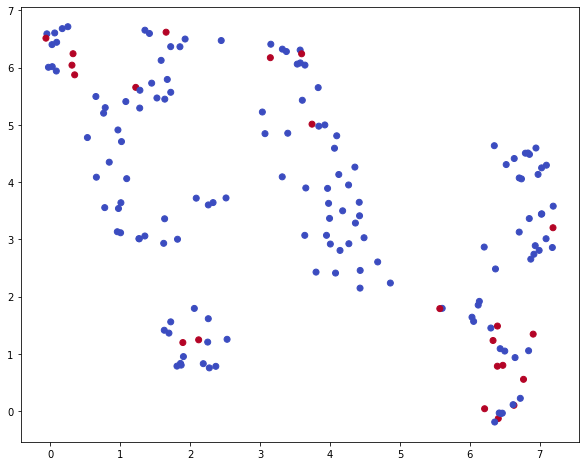

In [103]:
plt.figure(figsize=(10,8))
plt.scatter(u[:,0], u[:,1], c=df_y, cmap="coolwarm")

### 3. 1번의 모델에서 FullyConnectedLayer로 Feature를 뽑아오기, 뽑아온 Feature 가지고, ClinicalInformation.tsv로 시각화 하기

In [104]:
FeatureExtractor = ResNet.predict(TEST_GENERATOR)

C:\Users\user\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [106]:
FeatureExtractor.shape

(57, 7, 7, 2048)

In [107]:
u2 = fit.fit_transform(FeatureExtractor)

ValueError: Found array with dim 4. Estimator expected <= 2.

In [91]:
u2[:, 0]

array([-1.2336255 ,  5.1739473 ,  5.0745277 ,  3.243066  , -1.2430768 ,
       -0.9609163 ,  4.188263  ,  8.265291  , -1.4603771 , -1.5169642 ,
       -1.38972   ,  4.395979  ,  3.9705997 , -0.55311227,  2.4695427 ,
        2.603675  ,  5.283934  ,  6.1638055 ,  1.0702958 ,  3.4605138 ,
       -1.7007589 ,  4.00582   ,  6.4532833 ,  4.0078034 ,  4.516629  ,
       -1.694054  ,  0.27838898, -0.837749  , -0.6839551 ,  7.7538185 ,
        8.319998  ,  6.3278728 ,  4.3434353 ,  3.3760934 ,  4.1073356 ,
        4.4413953 , -1.3093255 ,  5.4856076 , -0.40385976, -1.0402014 ,
        0.66758233, -1.5189704 ,  5.7228684 ,  5.5501842 ,  2.8089035 ,
        6.174089  ,  7.331197  ,  6.6828303 ,  4.570281  ,  1.2289565 ,
        3.9966612 , -1.3130033 ,  1.6011554 , -1.7984744 , -1.6664016 ,
       -1.1609856 ,  5.35659   ,  4.967926  , -0.29787496, -0.7384832 ,
        3.537462  ,  7.1075845 ,  6.0663357 ,  2.2724147 ,  7.8634953 ,
        0.4427933 ,  1.0031089 , -0.17197077,  0.8503066 ,  8.17

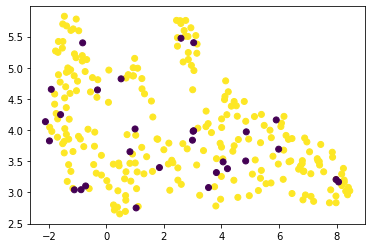

In [93]:
plt.scatter(u2[:, 0], u2[:, 1], c=y)

In [78]:
a = [1 for _ in range(238)] + [0 for _ in range(29)]
y = pd.Series(a)